# PRJEB61810 - Gurol et al.

Article link: [https://www.researchsquare.com/article/rs-4880585/v1](https://www.researchsquare.com/article/rs-4880585/v1).

In [9]:
suppressPackageStartupMessages({
    library(provoc)
    library(here)
    library(ggplot2)
    library(lubridate)
    library(dplyr)
    library(geodata)
    library(terra)
    library(tidyterra)
})

prj <- "PRJEB61810"
lineages_in_paper <- c("BA.2", "CH.1.1", "BA.5", "BQ.1", "XBB", "XBB.1.5", "XBB.1.9", "XBB.1.16", "XBB.s.3")


In [2]:
coco <- read.csv(
  here(
    "data/processed/",
    paste0(prj, "_processed.csv.gz")
  )
)
coco$mutation <- parse_mutations(coco$label)
head(coco)


,position,label,mutation,frequency,coverage,count,sra,date,sample_name,avg_spot_len,bases,bioproject,location,lat,lon,ww_population
,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,10386,+10387.T,ins:10387:1,0.110548824,14030,1551,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malmö,55.63,13.04,350000
2,10527,+10528.T,ins:10528:1,0.115302186,4666,538,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malmö,55.63,13.04,350000
3,1077,+1078.A,ins:1078:1,0.071404090,8753,625,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malmö,55.63,13.04,350000
4,11042,+11043.T,ins:11043:1,0.044637576,21977,981,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malmö,55.63,13.04,350000
5,11074,+11075.T,ins:11075:1,0.049914561,22238,1110,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malmö,55.63,13.04,350000
6,11074,+11075.TT,ins:11075:2,0.006340498,22238,141,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malmö,55.63,13.04,350000


Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


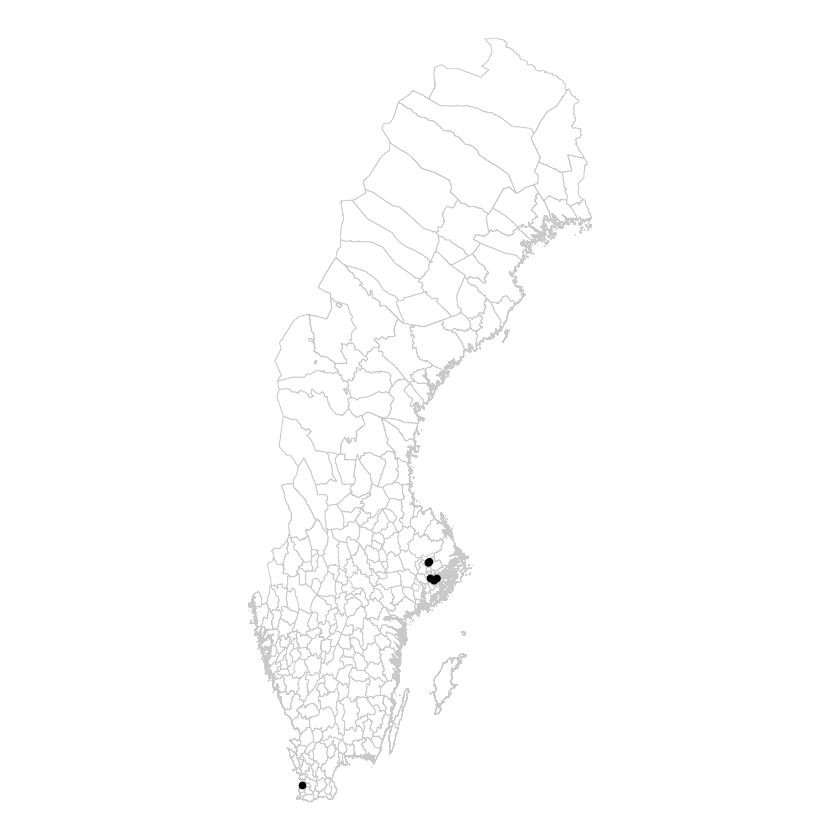

In [ ]:
sweden <- gadm(country = "Sweden", level = 2, path = ".")
locs <- coco |>
    select(sra, lat, lon) |>
    distinct() |>
    group_by(lat, lon) |>
    tally(name = "count")

ggplot() +
    theme_void() +
    geom_spatvector(data = sweden, colour = "lightgrey", fill = "white") +
    geom_point(data = locs, mapping = aes(x = lon, y = lat))


In [3]:
barcodes <- provoc::usher_barcodes()
available_lineages <- intersect(lineages_in_paper, rownames(barcodes))
barcodes <- filter_lineages(barcodes, available_lineages)
dim(barcodes)


[1]   8 128

In [4]:
system.time(
    res <- provoc(count / coverage ~ .,
        data = coco,
        lineage_defs = barcodes,
        by = "sra")
)
head(res)


   user  system elapsed 
 34.148   0.806  35.482 

,rho,ci_low,ci_high,lineage,sra,date,sample_name,avg_spot_len,bases,bioproject,location,lat,lon,ww_population
,<dbl>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,8.485457e-03,NA,NA,XBB.1.16,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malm,55.63,13.04,350000
2,1.196521e-02,NA,NA,XBB.1.9,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malm,55.63,13.04,350000
3,2.192989e-01,NA,NA,XBB.1.5,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malm,55.63,13.04,350000
4,2.678046e-01,NA,NA,CH.1.1,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malm,55.63,13.04,350000
5,9.828202e-09,NA,NA,XBB,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malm,55.63,13.04,350000
6,3.153469e-01,NA,NA,BQ.1,ERR12330860,2023-01-03,SAMEA114705162,185,833359305,PRJEB61810,Malm,55.63,13.04,350000


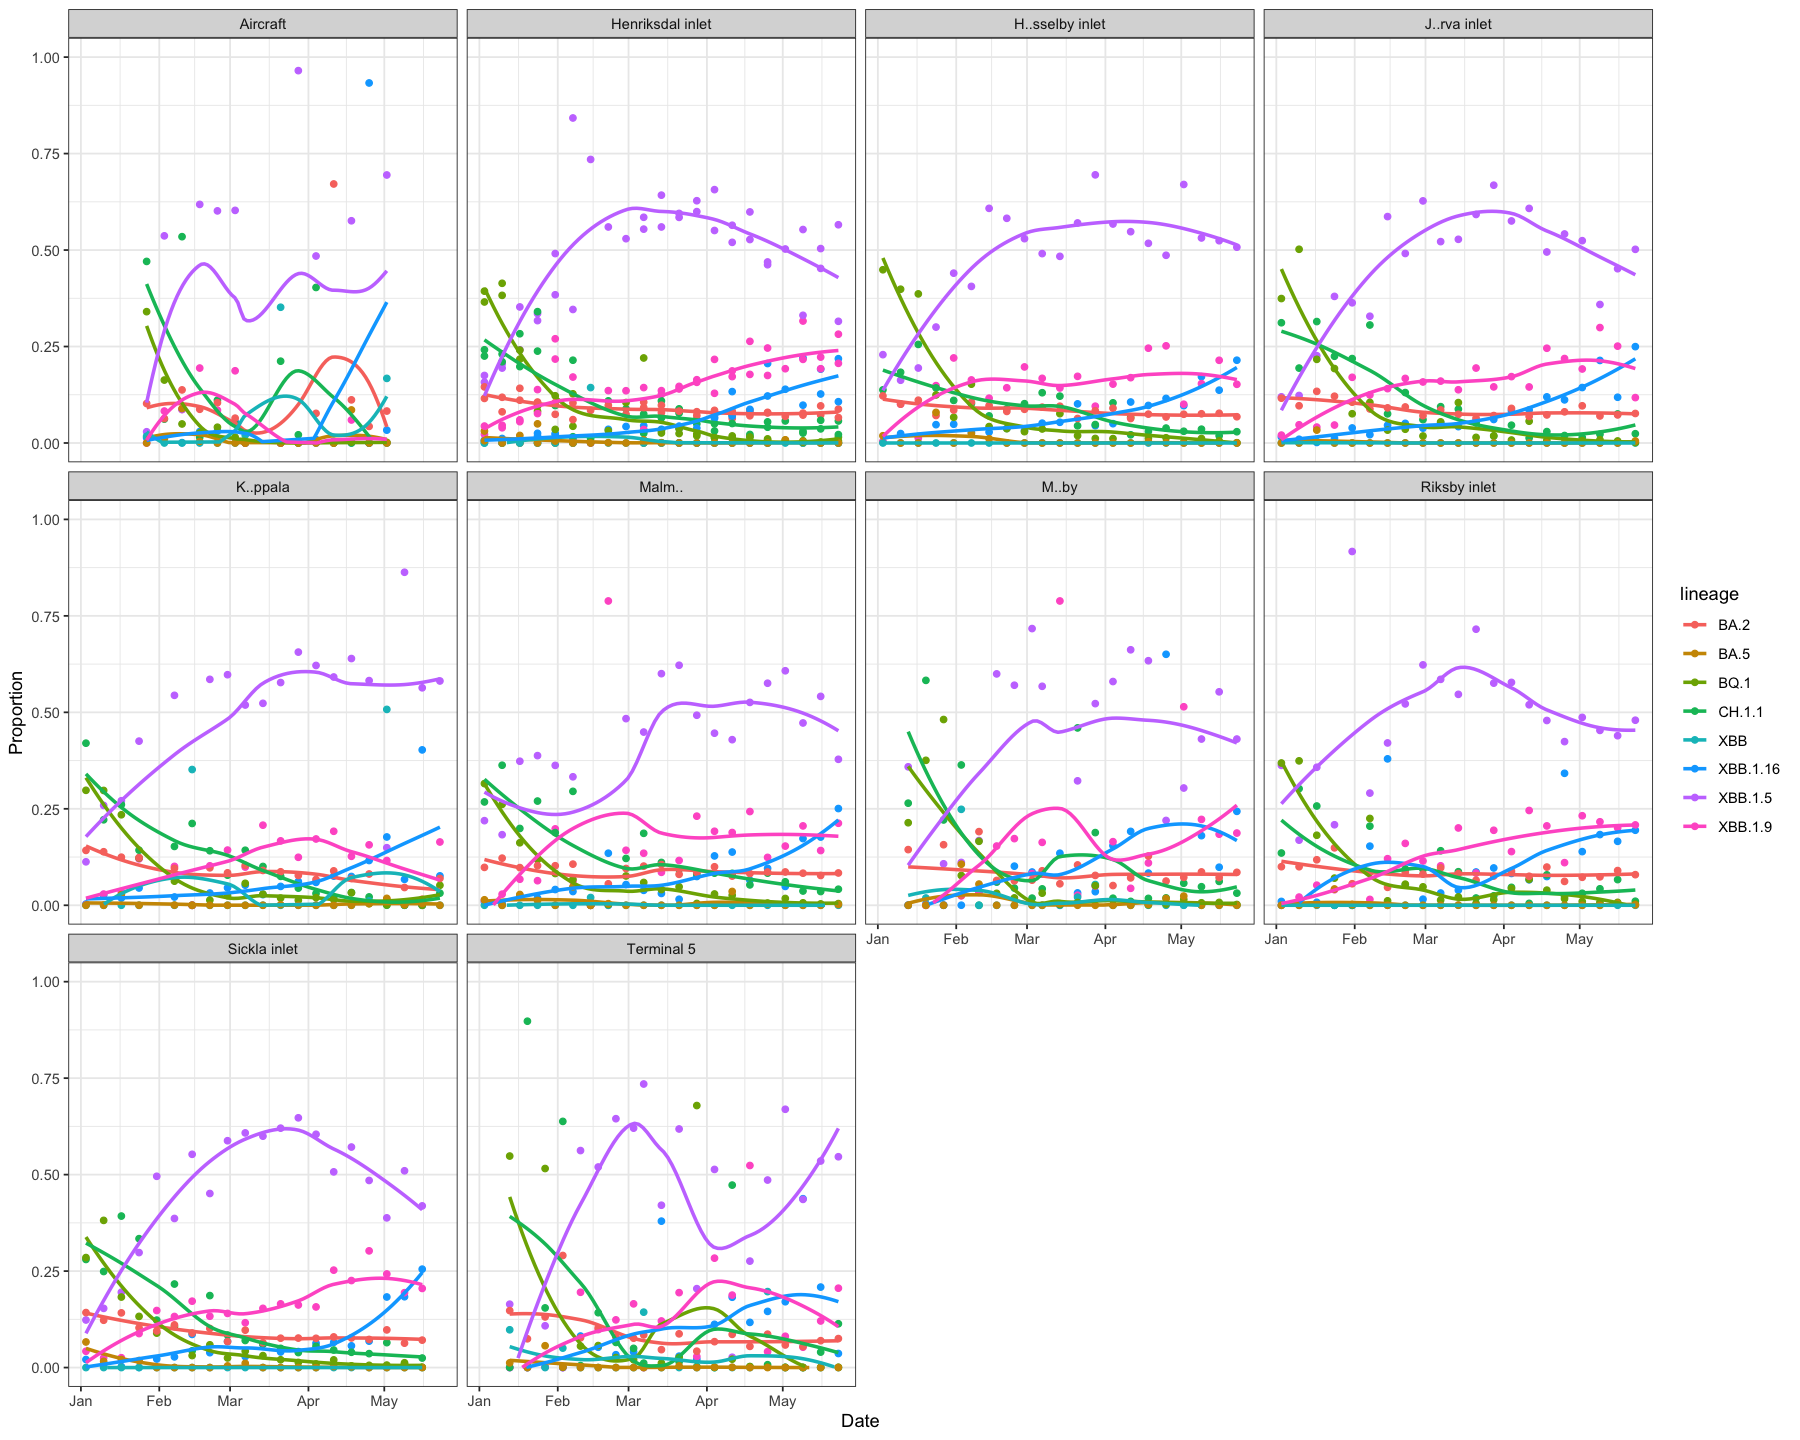

In [5]:
options(repr.plot.width = 15, repr.plot.height = 12)

res$date <- lubridate::ymd(res$date)

gg <- autoplot(res, date_col = "date") + facet_wrap(~location) +
    geom_smooth(formula = y ~ x, se = FALSE, method = "loess") +
    theme_bw()
suppressWarnings(print(gg))
